In [1]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
import folium
import json
from datetime import *
from fuzzywuzzy import fuzz
%matplotlib inline  
plt.style.use('fivethirtyeight')

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Read the raw data, the data from Yelp, merge them together and clean the variables

In [28]:
df = pd.read_csv("raw_data.csv")
df_restaurant = pd.read_csv("restaurants_raw_data.csv")

### Convert inspection date to datetime and keep a count for the past 15 months of the number of inspections


### We delete the businesses with no inspections or with more than 10 different inspections in the past 15 months given that they do not show possible recency/accuracy

In [29]:
df["inspection_date_datetime"] = pd.to_datetime(df["inspection_date"])
last_year_date = pd.Timestamp(date(2017, 6, 15))
df_last_year = df[df["inspection_date_datetime"] > last_year_date].drop_duplicates(["camis","inspection_date_datetime"])
df["inspection_count"] = df["camis"].map(df_last_year["camis"].value_counts())
df["inspection_count"] = df["inspection_count"].fillna(0)
df["inspection_count"] = df["inspection_count"].astype(int)
df = df[df["inspection_count"] != 0]
df = df[df["inspection_count"] <= 10]


### We also clean the format of a few points

In [ ]:
df["cuisine_description"] = np.where(df['cuisine_description'] == "CafÃ©/Coffee/Tea", "Coffee/Tea", df["cuisine_description"])
df["boro"] = np.where(df['boro'] == "BRONX", "Bronx", df["boro"])
df["boro"] = np.where(df['boro'] == "MANHATTAN", "Manhattan", df["boro"])
df["boro"] = np.where(df['boro'] == "BROOKLYN", "Broooklyn", df["boro"])
df["boro"] = np.where(df['boro'] == "QUEENS", "Queens", df["boro"])
df["boro"] = np.where(df['boro'] == "STATEN ISLAND", "Staten Island", df["boro"])

### We start with some initial visualizations to find any possible trend

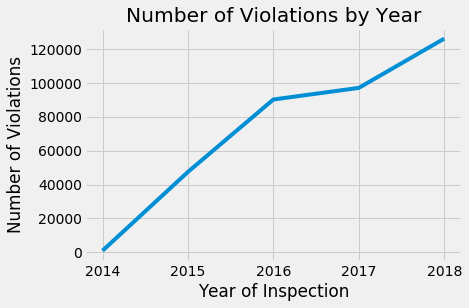

In [53]:
df_year = df.groupby(df["inspection_date_datetime"].map(lambda x: x.year))["score"].count()
plt.plot(df_year.index,df_year)
plt.title("Number of Violations by Year")
plt.ylabel("Number of Violations")
plt.xlabel("Year of Inspection")
plt.show()

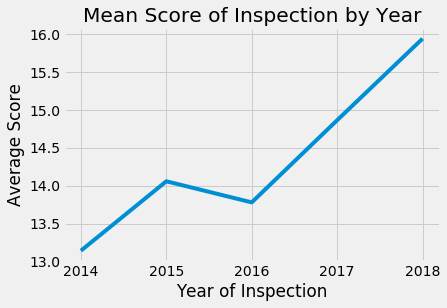

In [58]:
df_inspections = df.drop_duplicates(["camis","inspection_date_datetime"])
df_year_mean = df_inspections.groupby(df["inspection_date_datetime"].map(lambda x: x.year))["score"].mean()
plt.plot(df_year_mean.index,df_year_mean)
plt.title("Mean Score of Inspection by Year")
plt.ylabel("Average Score")
plt.xlabel("Year of Inspection")
plt.show()

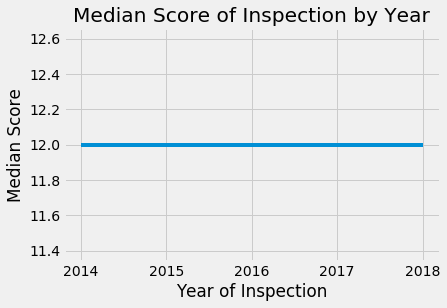

In [60]:
df_year_median = df_inspections.groupby(df["inspection_date_datetime"].map(lambda x: x.year))["score"].median()
plt.plot(df_year_median.index,df_year_median)
plt.title("Median Score of Inspection by Year")
plt.ylabel("Median Score")
plt.xlabel("Year of Inspection")
plt.show()

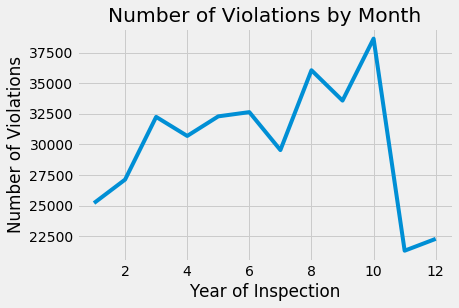

In [62]:
df_month = df.groupby(df["inspection_date_datetime"].map(lambda x: x.month))["score"].count()
plt.plot(df_month.index,df_month)
plt.title("Number of Violations by Month")
plt.ylabel("Number of Violations")
plt.xlabel("Year of Inspection")
plt.show()

### Keeping only one record for each restaurant and add the inspection count variable to the dataframe


In [4]:
df = df.sort_values("inspection_date_datetime",ascending=False)
df = df.drop_duplicates("camis")
df = df[df["grade"].notnull()]
df_restaurant = df_restaurant.drop_duplicates(["dba","street","zipcode"])
df_merged = df.merge(df_restaurant, on=["dba","street","zipcode"],how="left")

### Need to start by cleaning the mess that is the yelp data: keeping only the data that has price indication and the one where the name is close enough on Yelp


In [5]:
price_option=["$","$$","$$$","$$$$"]
df_price= df_merged[df_merged["yelp_price"].isin(price_option)]
df_price["yelp_fuzz"] = df_price[["dba","yelp_name"]].apply(lambda x: fuzz.partial_ratio(x['dba'], x['yelp_name'].upper()), axis=1)
df_cleaned = df_price[df_price["yelp_fuzz"]>65]
df_cleaned = df_cleaned.sort_values(by=["yelp_price"],ascending = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Reformatting a few columns to make them easier to manipulate and we create new variables for food and prices applying our custom formatting

In [6]:
def reformat_price(price):
    #Simply reformats the price levels of the different businesses
    if price == "$":
        category = "1- Cheap"
    elif price == "$$":
        category = "2 - Reasonable"
    elif price == "$$$":
        category = "3 - Expensive"
    elif price == "$$$$":
        category = "4 - Luxurious"
    return category

def is_food(cuisine_description):
    #Separates food restaurants with the other types of business
    food = ["American","Peruvian","Soups & Sandwiches","Chinese","Sandwiches","Mexican","Chicken","Turkish","Sandwiches/Salads/Mixed Buffet","Hamburgers","Chinese/Japanese","Italian","Spanish","Latin (Cuban, Dominican, Puerto Rican, South & Central American)","French","Pizza/Italian","Creole","Pizza","Japanese","Seafood","Asian","African","Barbecue","Jewish/Kosher","Tapas","Caribbean","Salads","Steak","Tex-Mex","Mediterranean","Pakistani","Irish","Vegetarian","Bangladeshi","Australian","Thai","Soups","Middle Eastern","Russian","Indian","Brazilian","Greek","Korean","Vietnamese/Cambodian/Malaysia","Hotdogs","Hawaiian","Soul Food", "Filipino","Creole/Cajun","Eastern European","Armenian","Afghan","Chinese/Cuban","English","Polish","Continental","Hotdogs/Pretzels","German","Egyptian","Indonesian","Ethiopian","Moroccan","Portuguese","Californian","Cajun","Scandinavian","Southwestern","Chilean","Iranian","Polynesian","Czech","Basque"]
    other = ["Pancakes/Waffles","Not Listed/Not Applicable","Nuts/Confectionary","Fruits/Vegetables"]
    if cuisine_description in food:
        category = "Food"
    elif cuisine_description in other:
        category = "Other"
    else:
        category = cuisine_description
    
    return category

def give_grade(score):
    #Give grade based on the score of the inspection
    if score < 14:
        grade = "A"
    elif score < 28:
        grade = "B"
    else:
        grade = "C"
    
    return grade

In [7]:
df_cleaned["food"] = df_cleaned["cuisine_description"].apply(is_food)
df_cleaned["synthetic_grade"] = df_cleaned["score"].apply(give_grade)
df_cleaned["yelp_price"] = df_cleaned["yelp_price"].apply(reformat_price)

# We create a chloropleth to visualize the data by zipcode

### Aggregate the data per zipcode to create the choropleth

In [8]:
df_map = df_cleaned.dropna(subset=['zipcode'])
df_map.zipcode.unique()
df_map["zipcode"] = df_map["zipcode"].astype(int)
df = df_map.groupby("zipcode")["score"].mean() 
new_df = pd.DataFrame(data = {"zip": df.index, "mean_score": df}) 
df_proportion =  100*(df_map[df_map["score"] < 14].groupby("zipcode")["score"].count() / df_map.groupby("zipcode")["score"].count())
new_df = pd.DataFrame(data = {"zip": df.index,"proportion": df_proportion}) 
new_df["zip"] = new_df["zip"].astype(str)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### We prepare the map template for the choropleth

In [9]:
with open("nyc-zip-code-tabulation-areas-polygons.geojson","r") as jsonFile:
    data = json.load(jsonFile)
tmp = data
geozips = []
for i in range(len(tmp["features"])):
    if tmp["features"][i]["properties"]["postalCode"] in list(new_df["zip"].unique().astype(str)):
        geozips.append(tmp["features"][i])
        
new_json = dict.fromkeys(["type","features"])
new_json["type"] = "FeatureCollection"
new_json["features"] = geozips

open("updated-file.json","w").write(json.dumps(new_json, sort_keys = True, indent=4, separators = (",",": ")))

1762268

In [10]:
def create_map(table,zips,mapped_feature, add_text=""):
    #Create the map based on the zip-coded data and the feature
    nyc_geo = r"updated-file.json"
    m = folium.Map(location = [40.7128, -74.0060], zoom_start = 11)
    m.choropleth(
        geo_data = nyc_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        key_on = "feature.properties.postalCode",
        columns = [zips,mapped_feature],
        fill_color = "RdYlGn",
        legend_name = "Percentage of Restaurants Graded A Across NYC",
        threshold_scale= [50, 60, 70, 80, 90, 100]
    )
    folium.LayerControl().add_to(m)
    m.save(outfile = mapped_feature + "_map.html")

### We create and store the chloropleth

In [11]:
create_map(new_df,"zip","proportion")

# Diving deeper in the data

### Looking at Overall Grades

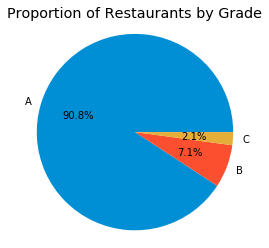

In [12]:
plot1df = df_cleaned.groupby("synthetic_grade")["camis"].count() / df_cleaned.groupby("synthetic_grade")["camis"].count().sum()

plt.pie(plot1df,autopct ="%1.1f%%",labels=plot1df.index)
plt.title("Proportion of Restaurants by Grade")
plt.axis("image")
plt.show()

#plot1df.plot(kind="pie",legend = False,labels=None,autopct = "%1.1f%%" ,subplots = True, figsize=(4,4),title="Proportion of Restaurants by Grade")

food
Bagels/Pretzels                                              129
Bakery                                                       494
Bottled beverages, including water, sodas, juices, etc.       51
Coffee/Tea                                                  1200
Delicatessen                                                 182
Donuts                                                       476
Food                                                       13589
Ice Cream, Gelato, Yogurt, Ices                              262
Juice, Smoothies, Fruit Salads                               214
Other                                                        146
Name: camis, dtype: int64

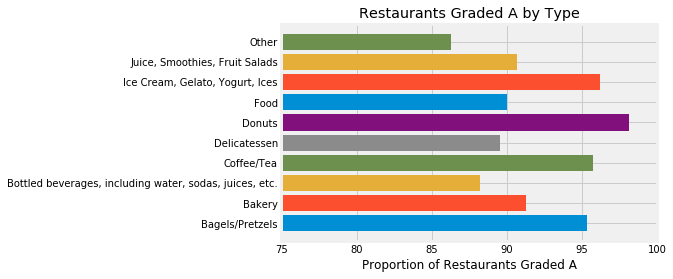

In [13]:
plot2df = 100*(df_cleaned[df_cleaned["score"] < 14].groupby("food")["camis"].count() / df_cleaned.groupby("food")["camis"].count())
plt.barh(plot2df.index,plot2df,color=['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c'])
plt.title("Restaurants Graded A by Type")
plt.style.use("fivethirtyeight")
plt.xlim((75,100))
plt.xlabel("Proportion of Restaurants Graded A")
df_cleaned.groupby("food")["camis"].count()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


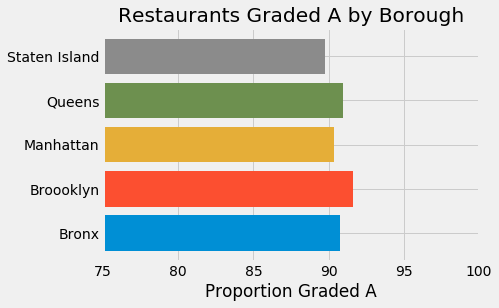

In [14]:
#Is there any distinction by Borough?
df_boro = df_cleaned[df_cleaned["boro"] != "Missing"]
plot2df = 100*(df_boro[df_cleaned["score"] < 14].groupby("boro")["camis"].count() / df_boro.groupby("boro")["camis"].count())
plt.barh(plot2df.index,plot2df,color=['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c'])
plt.title("Restaurants Graded A by Borough")
plt.xlim((75,100))
plt.xlabel("Proportion Graded A")
plt.show()
#plot2df.plot(kind="bar", subplots = True, figsize=(4,4),ylim = (0.8,1))

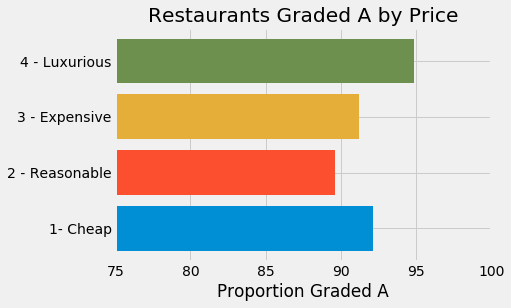

In [15]:
plot4df = 100*(df_cleaned[df_cleaned["score"] < 14].groupby("yelp_price")["camis"].count() / df_cleaned.groupby("yelp_price")["camis"].count())
plt.barh(plot4df.index,plot4df,color=['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c'])
plt.title("Restaurants Graded A by Price")
plt.xlabel("Proportion Graded A")
plt.xlim((75,100))
plt.show()

             yelp_rating    score
yelp_rating      1.00000  0.03029
score            0.03029  1.00000


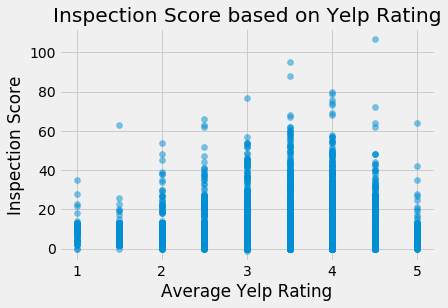

In [16]:
df_cleaned["yelp_rating"].unique()
plt.scatter(df_cleaned["yelp_rating"],df_cleaned["score"],alpha=0.5)
plt.title("Inspection Score based on Yelp Rating")
plt.ylabel("Inspection Score")
plt.xlabel("Average Yelp Rating")
print(df_cleaned[["yelp_rating","score"]].corr())

                   yelp_review_count     score
yelp_review_count           1.000000  0.048933
score                       0.048933  1.000000


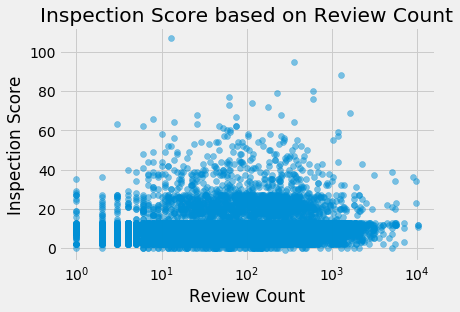

In [17]:
plt.scatter(df_cleaned["yelp_review_count"],df_cleaned["score"],alpha=0.5)
plt.title("Inspection Score based on Review Count")
plt.ylabel("Inspection Score")
plt.xlabel("Review Count")
plt.xscale("log")
print(df_cleaned[["yelp_review_count","score"]].corr())
#Log de review count

            chain_size     score
chain_size    1.000000 -0.117302
score        -0.117302  1.000000


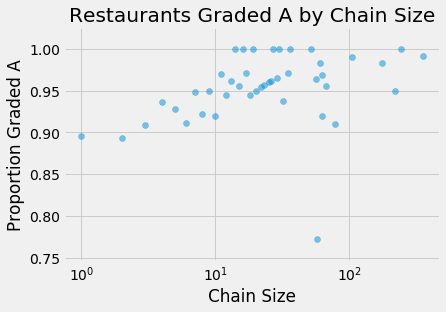

In [18]:
#Is there any distinction by being a chain? AS EXPECTED
df_cleaned["chain_size"] = df_cleaned["dba"].map(df_cleaned["dba"].value_counts())
plot5df = df_cleaned[df_cleaned["score"] < 14].groupby("chain_size")["camis"].count() / df_cleaned.groupby("chain_size")["camis"].count()
plt.scatter(plot5df.index, plot5df, alpha=0.5)
plt.title("Restaurants Graded A by Chain Size")
plt.ylabel("Proportion Graded A")
plt.xlabel("Chain Size")
plt.xscale("log")
print(df_cleaned[["chain_size","score"]].corr())

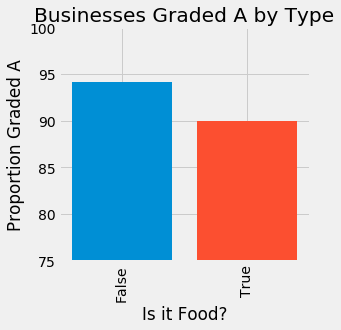

In [19]:
df_cleaned["is_food_bool"] = [x == "Food" for x in df_cleaned["food"]]
#df_cleaned["is_other_bool"] = [x == "Other" for x in df_cleaned["food"]]
plot7df = 100*(df_cleaned[df_cleaned["score"] < 14].groupby("is_food_bool")["camis"].count() / df_cleaned.groupby("is_food_bool")["camis"].count())
plot7df.plot(kind="bar", subplots = True, figsize=(4,4),ylim = (0.8,1))
plt.bar(plot7df.index,plot7df,color=['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c'])
plt.title("Businesses Graded A by Type")
plt.ylabel("Proportion Graded A")
plt.xlabel("Is it Food?")
plt.ylim((75,100))
plt.show()

                  inspection_count     score
inspection_count          1.000000  0.207953
score                     0.207953  1.000000


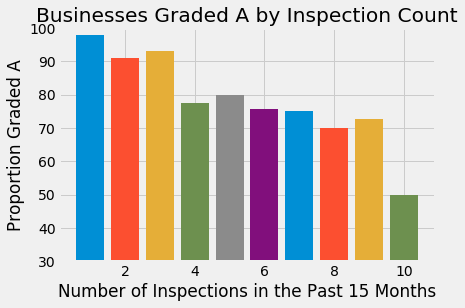

In [25]:
plot8df = 100*(df_cleaned[df_cleaned["score"] < 14].groupby("inspection_count")["camis"].count() / df_cleaned.groupby("inspection_count")["camis"].count())
plt.bar(plot8df.index,plot8df,color=['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c'])
plt.title("Businesses Graded A by Inspection Count")
plt.ylabel("Proportion Graded A")
plt.xlabel("Number of Inspections in the Past 15 Months")
plt.ylim((30,100))
print(df_cleaned[["inspection_count","score"]].corr())
plt.show()


In [22]:
#Is there any distinction by hours of opening?
print(df_cleaned["yelp_hours"].unique())
#3-4 categories 
#https://www.google.com/search?q=gg+joy+plot&source=lnms&tbm=isch&sa=X&ved=0ahUKEwjXrf76hbTfAhUxzoUKHTeVBuAQ_AUIDigB&biw=1163&bih=554#imgrc=9WOD1oikzBwzDM:

["[{'open': [{'is_overnight': False, 'start': '1100', 'end': '2200', 'day': 0}, {'is_overnight': False, 'start': '1100', 'end': '2200', 'day': 1}, {'is_overnight': False, 'start': '1100', 'end': '2200', 'day': 2}, {'is_overnight': False, 'start': '1100', 'end': '2200', 'day': 3}, {'is_overnight': False, 'start': '1100', 'end': '2300', 'day': 4}, {'is_overnight': False, 'start': '1100', 'end': '2300', 'day': 5}, {'is_overnight': False, 'start': '1200', 'end': '2030', 'day': 6}], 'hours_type': 'REGULAR', 'is_open_now': True}]"
 "{'open': [{'is_overnight': False, 'start': '0500', 'end': '0000', 'day': 0}, {'is_overnight': False, 'start': '0500', 'end': '0000', 'day': 1}, {'is_overnight': False, 'start': '0500', 'end': '0000', 'day': 2}, {'is_overnight': False, 'start': '0500', 'end': '0000', 'day': 3}, {'is_overnight': False, 'start': '0500', 'end': '0000', 'day': 4}, {'is_overnight': False, 'start': '0500', 'end': '0000', 'day': 5}, {'is_overnight': False, 'start': '0500', 'end': '0000',

In [23]:
#question 1: is it overnight?
#question 2:closes between 3 and 5?
#question 3: opens early/closes late?
#question 4: NA?
# = 5 categories

In [20]:
#Also, I should isolate food throughout the analysis to avoid bias
#What do we do with all the restaurants/biz that i couldnt find on yelp? It does give an info
#It definitely helps understand why the ratio goes up as its probably correlated
df_cleaned["std_yelp_rating"] = (df_cleaned["yelp_rating"]-df_cleaned["yelp_rating"].mean())/df_cleaned["yelp_rating"].std()
df_cleaned["std_yelp_review_count"] = (df_cleaned["yelp_review_count"]-df_cleaned["yelp_review_count"].mean())/df_cleaned["yelp_review_count"].std()
df_cleaned["std_chain_size"] = (df_cleaned["chain_size"]-df_cleaned["chain_size"].mean())/df_cleaned["chain_size"].std()
df_cleaned.to_csv("cleanedv1.csv")